In [1]:
import os
import numpy as np
import cv2
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

# Task 1 : Create Global Color Histogram

In [2]:
## Images and Descriptors Location 

DATASET_FOLDER = 'MSRC_ObjCategImageDatabase_v2'
OUT_FOLDER = 'descriptors'
OUT_SUBFOLDER = 'globalRGBhisto' ## Output Folder for Color Histogram 

In [3]:
from cvpr_computedescriptors import create_global_color_hist

create_global_color_hist(8, # Level of Quantization
                         DATASET_FOLDER,
                         OUT_FOLDER,
                         OUT_SUBFOLDER) # Creates Descriptor based on Color Histogram 

Successfully Created Global Color Descriptors


In [36]:
from cvpr_visualsearch import load_descriptors
from cvpr_compare import cvpr_compare
from random import randint

DESCRIPTOR_FOLDER = 'descriptors'
DESCRIPTOR_SUBFOLDER = 'globalRGBhisto'
IMAGE_FOLDER = 'MSRC_ObjCategImageDatabase_v2'

ALLFILES , COLOR_HIST_ALLFEAT = load_descriptors(IMAGE_FOLDER,
                                                         DESCRIPTOR_FOLDER,
                                                         DESCRIPTOR_SUBFOLDER)

# Pick a random image as the query
NIMG = COLOR_HIST_ALLFEAT.shape[0]
queryimg = randint(0, NIMG - 1)

# Compute the distance between the query and all other descriptors
dst = []
query = COLOR_HIST_ALLFEAT[queryimg]
for i in range(NIMG):
    candidate = COLOR_HIST_ALLFEAT[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst.append((distance, i))

# Sort the distances
dst.sort(key=lambda x: x[0])


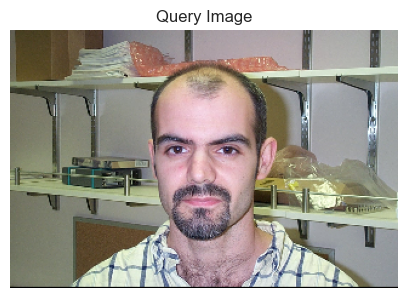

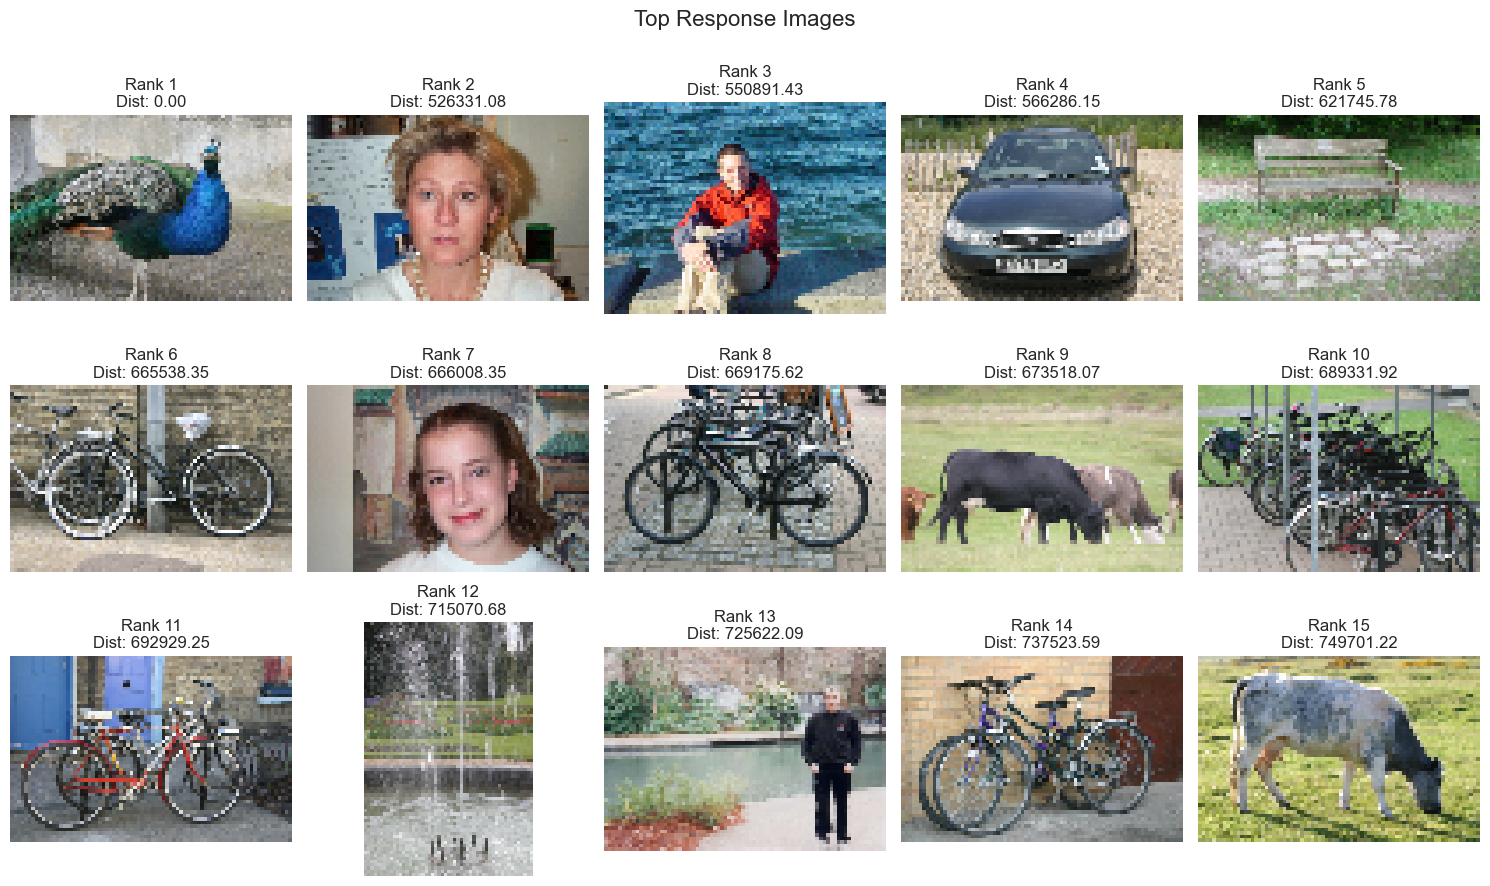

In [37]:
import matplotlib.pyplot as plt
import cv2

def display_query_and_top_responses(query_img_index, 
                                    response_indices, 
                                    file_paths, num_responses=15, grid_shape=(3, 5)):
    """
    Display a query image and the top response images in a grid.

    Parameters:
        query_img_index (int): Index of the query image in file_paths.
        response_indices (list of tuples): List of tuples where each tuple contains (distance, index) for response images.
        file_paths (dict): Dictionary mapping image indices to their file paths.
        num_responses (int): Number of top responses to display. Default is 15.
        grid_shape (tuple): Shape of the grid layout for response images. Default is (3, 5).
    """
    # Display the query image
    plt.figure(figsize=(5, 5))
    query_image_path = file_paths[query_img_index]
    query_image = cv2.imread(query_image_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    plt.show()

    # Display the top response images in a grid layout
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle("Top Response Images", fontsize=16)

    for i in range(min(num_responses, rows * cols)):
        img_index = response_indices[i+1][1]  # Index of response image
        img_path = file_paths[img_index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))  # Resize for display

        # Determine position in the grid
        row, col = divmod(i, cols)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Rank {i + 1}\nDist: {response_indices[i][0]:.2f}")
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust top to fit the main title
    plt.show()
    
display_query_and_top_responses(query_img_index=queryimg, 
                                    response_indices=dst, 
                                    file_paths=ALLFILES, num_responses=15, grid_shape=(3, 5))

# Task 2 : Generate Precision Recall Curve

In [38]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

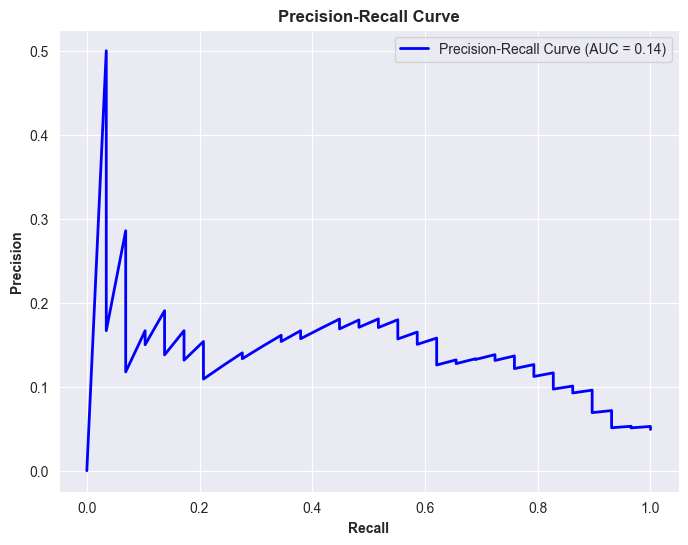

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc

def plot_precision_recall_curve(response_class, query_class):
    """
    Calculate precision-recall values and plot the Precision-Recall curve.

    Parameters:
        response_class (list): List of classes for the retrieved items.
        query_class: The class of the query item to calculate relevance against.
    """
    precision = []
    recall = []
    relevant_retrieved = 0
    total_relevant = sum(1 for cls in response_class if cls == query_class)

    # Calculate precision and recall at each point
    for i, cls in enumerate(response_class):
        if cls == query_class:
            relevant_retrieved += 1

        current_precision = relevant_retrieved / (i + 1)
        current_recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0

        precision.append(current_precision)
        recall.append(current_recall)

    # Calculate AUC for the precision-recall curve
    pr_auc = auc(recall, precision)

    # Plotting
    sns.set_style("darkgrid")
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall', fontweight='bold')
    plt.ylabel('Precision', fontweight='bold')
    plt.title('Precision-Recall Curve', fontweight='bold')
    plt.legend(loc='best')
    plt.show()

    return None

plot_precision_recall_curve(response_class, query_class)

# Task 3 : Spatial Grid (Colour and Texture)

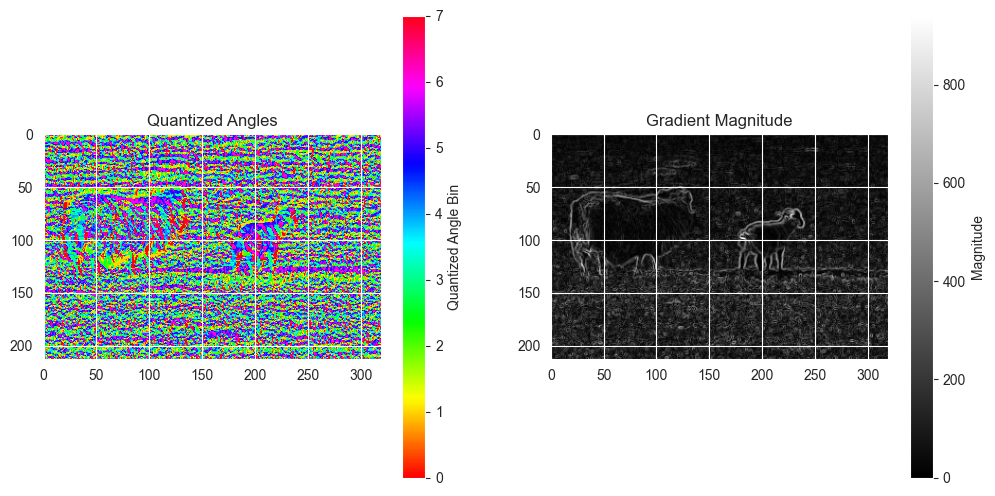

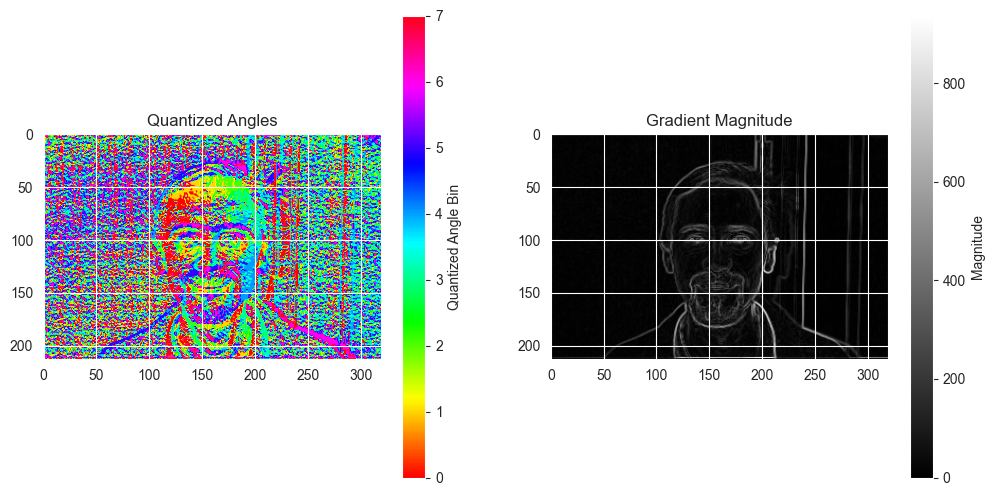

In [40]:
from cvpr_computedescriptors import sobel_quantization

for image_path in ALLFILES[:2]:
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Perform Sobel and angular quantization
    quantized_angles, quantized_magnitudes,magnitude = sobel_quantization(image, num_bins=8)

    # Visualize the quantized angles and magnitude
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(quantized_angles, cmap='hsv')  # Visualize quantized angles
    plt.title("Quantized Angles")
    plt.colorbar(label="Quantized Angle Bin")

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude, cmap='gray')  # Visualize magnitude
    plt.title("Gradient Magnitude")
    plt.colorbar(label="Magnitude")

    plt.show()

In [58]:
from cvpr_computedescriptors import color_texture_grid_descriptor

num_angular_bins = 8 

GRID_COLOR_TEXT_ALLFEAT = [] 
for IMG_PATH in ALLFILES:
    image = cv2.imread(IMG_PATH)
    temp_overall_descriptor = color_texture_grid_descriptor(image, grid_size=(8, 8), 
                                                            color_bins=8, sobel_bins=8)
    GRID_COLOR_TEXT_ALLFEAT.append(temp_overall_descriptor)

GRID_COLOR_TEXT_ALLFEAT = np.array(GRID_COLOR_TEXT_ALLFEAT)

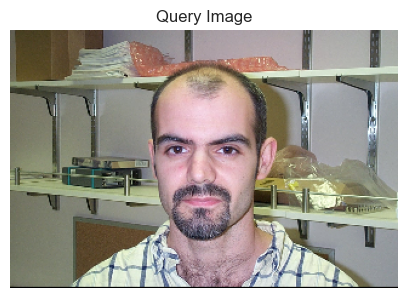

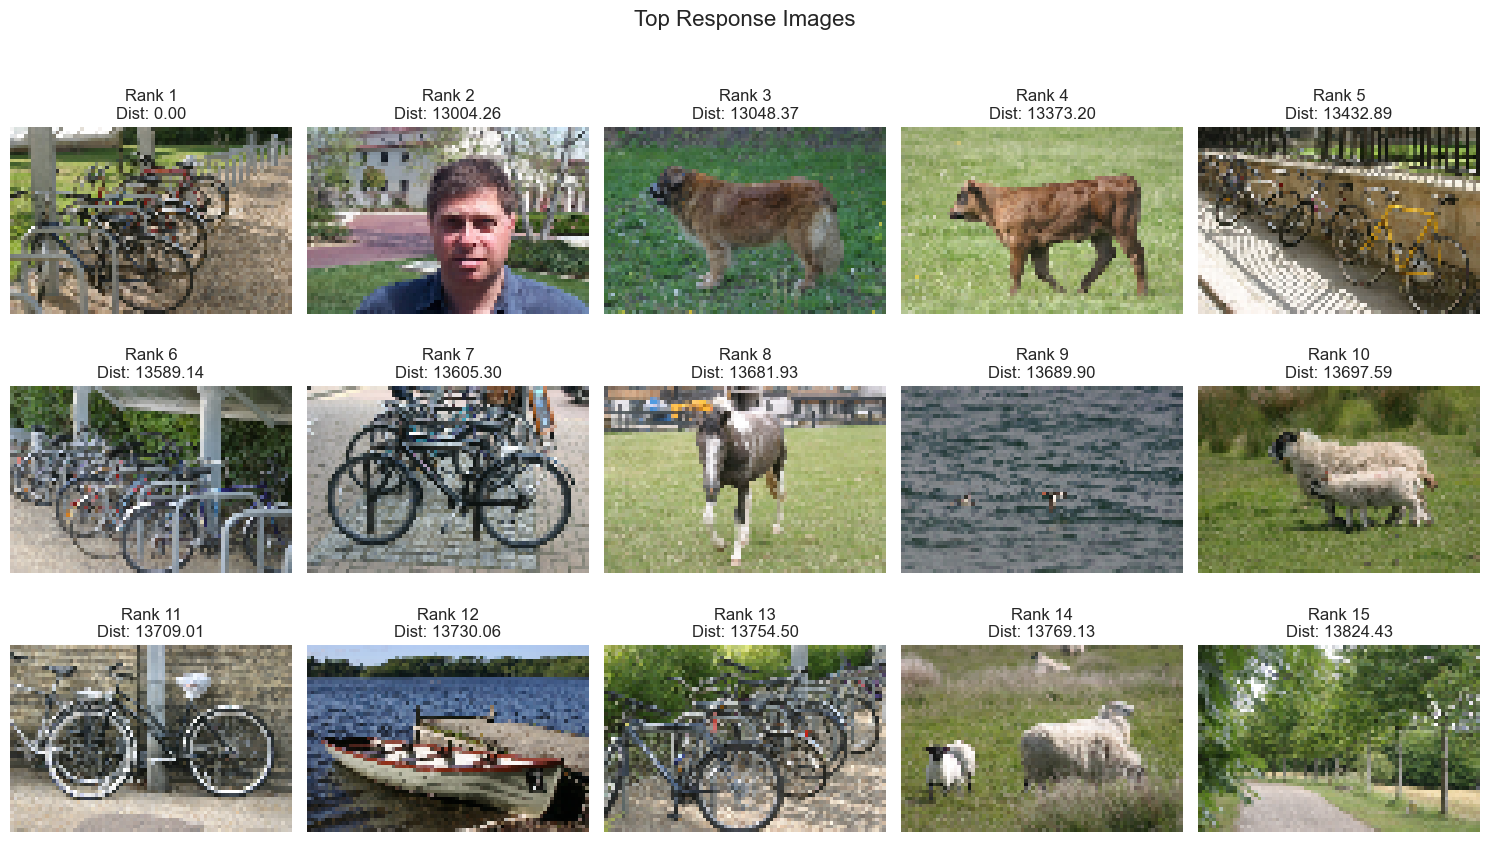

In [59]:
# Compute the distance between the query and all other descriptors
dst_grid_color_text = []
query = GRID_COLOR_TEXT_ALLFEAT[queryimg]
for i in range(NIMG):
    candidate = GRID_COLOR_TEXT_ALLFEAT[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst_grid_color_text.append((distance, i))

# Sort the distances
dst_grid_color_text.sort(key=lambda x: x[0])

display_query_and_top_responses(query_img_index = queryimg, 
                                    response_indices=dst_grid_color_text, 
                                    file_paths = ALLFILES, num_responses=15, grid_shape=(3, 5))

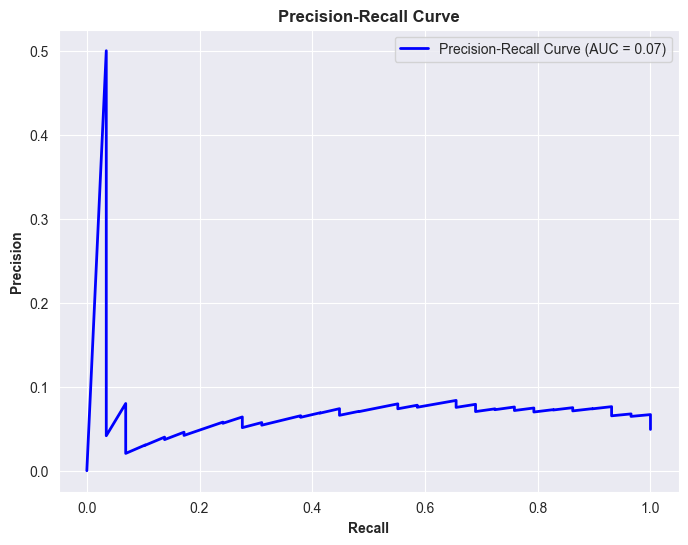

In [60]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst_grid_color_text[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

plot_precision_recall_curve(response_class, query_class)

### Task 3.X: Extra Experimentation

In [44]:
num_angular_bins = 8 

ANGULAR_HIST_ALLFEAT = []
MAGNITUDE_HIST_ALLFEAT = []

for IMG_PATH in ALLFILES:
    image = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
    
    # Perform Sobel and angular quantization
    quantized_angles, quantized_magnitudes,magnitude = sobel_quantization(image, 
                                                                                  num_bins=num_angular_bins)
   
    temp_ang_arr = [] # Contains individual img angular hist data
    temp_mag_arr = [] # Contains individual img magnitude hist data 
    
    for i in range(num_angular_bins):
        temp_ang_arr.append(sum(quantized_angles.flatten() == i))
        temp_mag_arr.append(sum(quantized_magnitudes.flatten() == i))
        
    ANGULAR_HIST_ALLFEAT.append(temp_ang_arr)
    MAGNITUDE_HIST_ALLFEAT.append(temp_mag_arr)
    
ANGULAR_HIST_ALLFEAT = np.array(ANGULAR_HIST_ALLFEAT) # Contains angular Hist for all the images
MAGNITUDE_HIST_ALLFEAT = np.array(MAGNITUDE_HIST_ALLFEAT) # Contains magnitude Hist for all the images

In [45]:
COL_ANG_HIST_ALLFEAT = np.concatenate((COLOR_HIST_ALLFEAT, ANGULAR_HIST_ALLFEAT), axis=1)
COL_MAG_HIST_ALLFEAT = np.concatenate((COLOR_HIST_ALLFEAT, MAGNITUDE_HIST_ALLFEAT), axis=1)

COL_ANG_MAG_HIST_ALLFEAT = np.concatenate((COL_ANG_HIST_ALLFEAT, MAGNITUDE_HIST_ALLFEAT), axis=1)


#### Task 3.1 : Peformance Based on Colour + Angular Histogram  

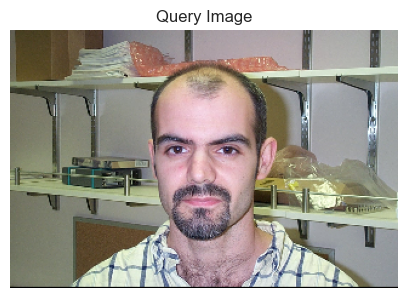

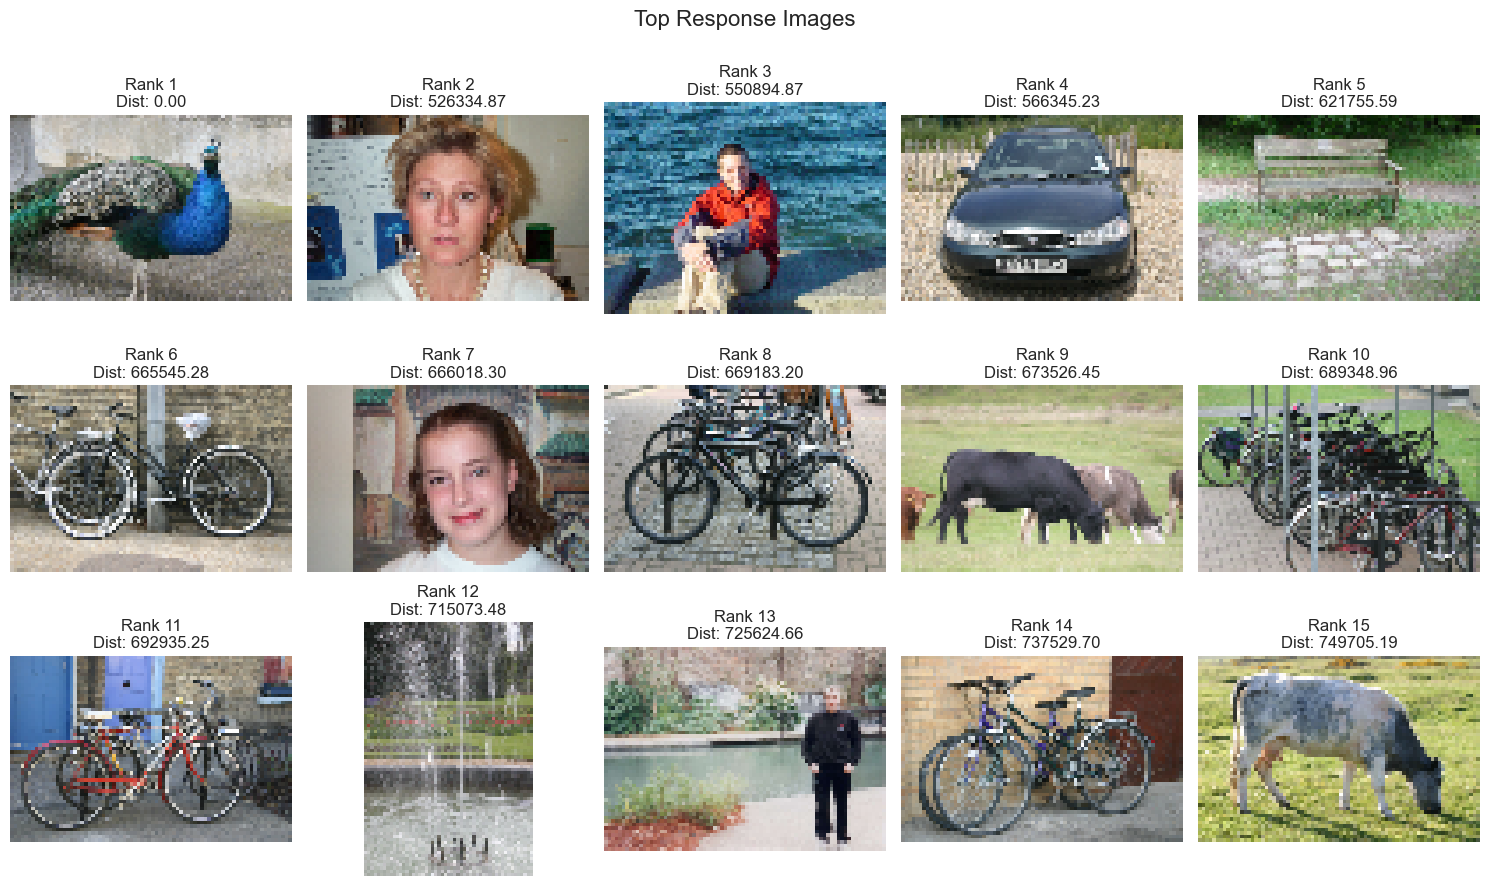

In [46]:
# Compute the distance between the query and all other descriptors
dst_col_ang = []
query = COL_ANG_HIST_ALLFEAT[queryimg]
for i in range(NIMG):
    candidate = COL_ANG_HIST_ALLFEAT[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst_col_ang.append((distance, i))

# Sort the distances
dst_col_ang.sort(key=lambda x: x[0])

display_query_and_top_responses(query_img_index = queryimg, 
                                    response_indices=dst_col_ang, 
                                    file_paths = ALLFILES, num_responses=15, grid_shape=(3, 5))

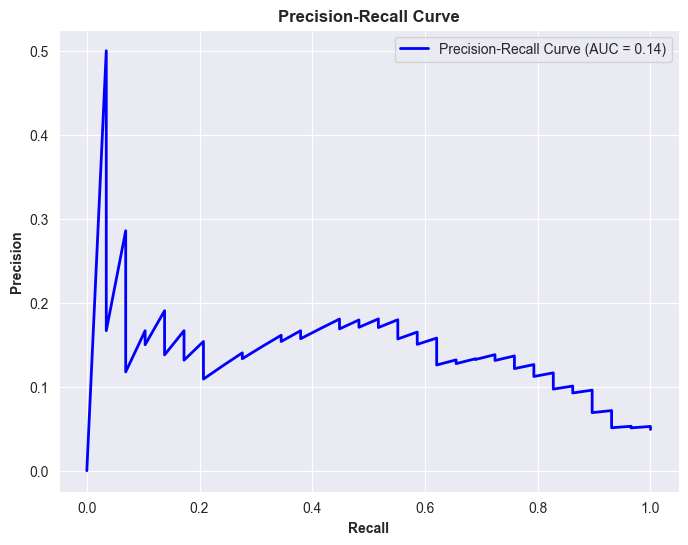

In [47]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst_col_ang[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

plot_precision_recall_curve(response_class, query_class)

#### 3.2 : Peformance Based on Colour + Mag Histogram  

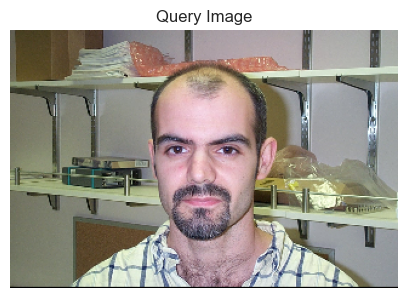

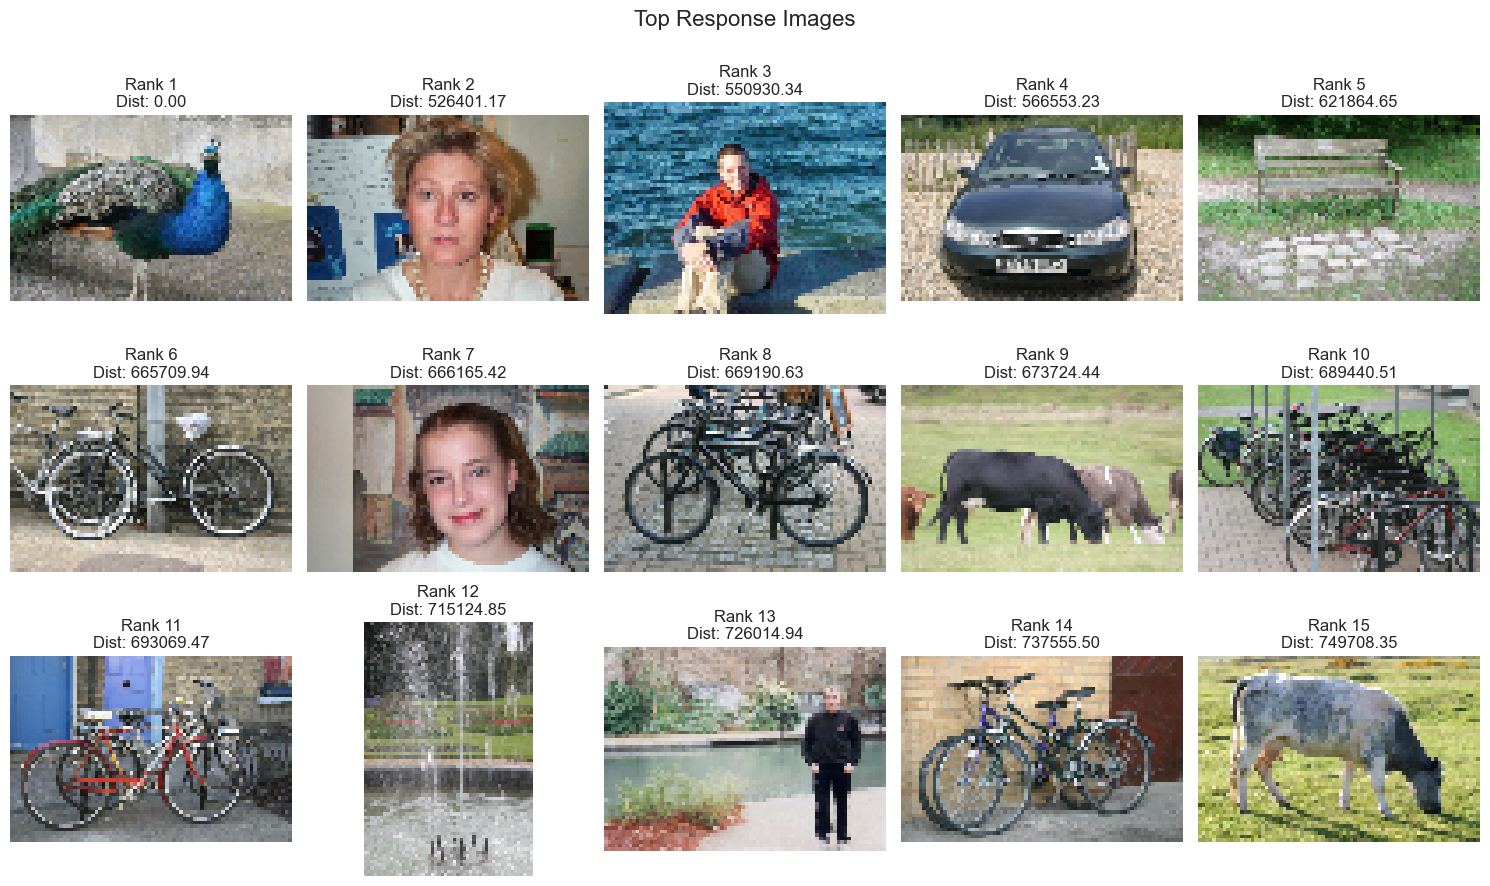

In [48]:
# Compute the distance between the query and all other descriptors
dst_col_mag = []
query = COL_MAG_HIST_ALLFEAT[queryimg]
for i in range(NIMG):
    candidate = COL_MAG_HIST_ALLFEAT[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst_col_mag.append((distance, i))

# Sort the distances
dst_col_mag.sort(key=lambda x: x[0])

display_query_and_top_responses(query_img_index = queryimg, 
                                    response_indices=dst_col_mag, 
                                    file_paths = ALLFILES, num_responses=15, grid_shape=(3, 5))

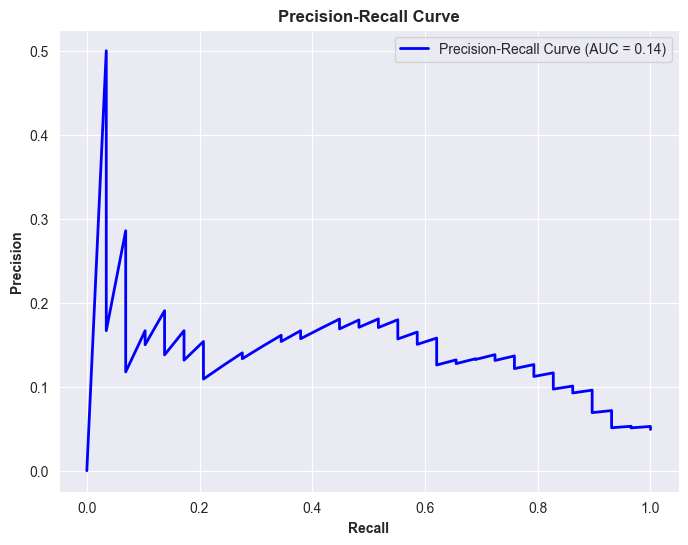

In [49]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst_col_mag[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

plot_precision_recall_curve(response_class, query_class)

### 3.3 Experimentation 

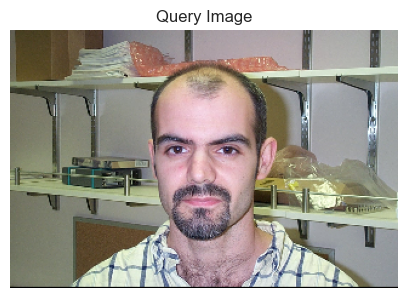

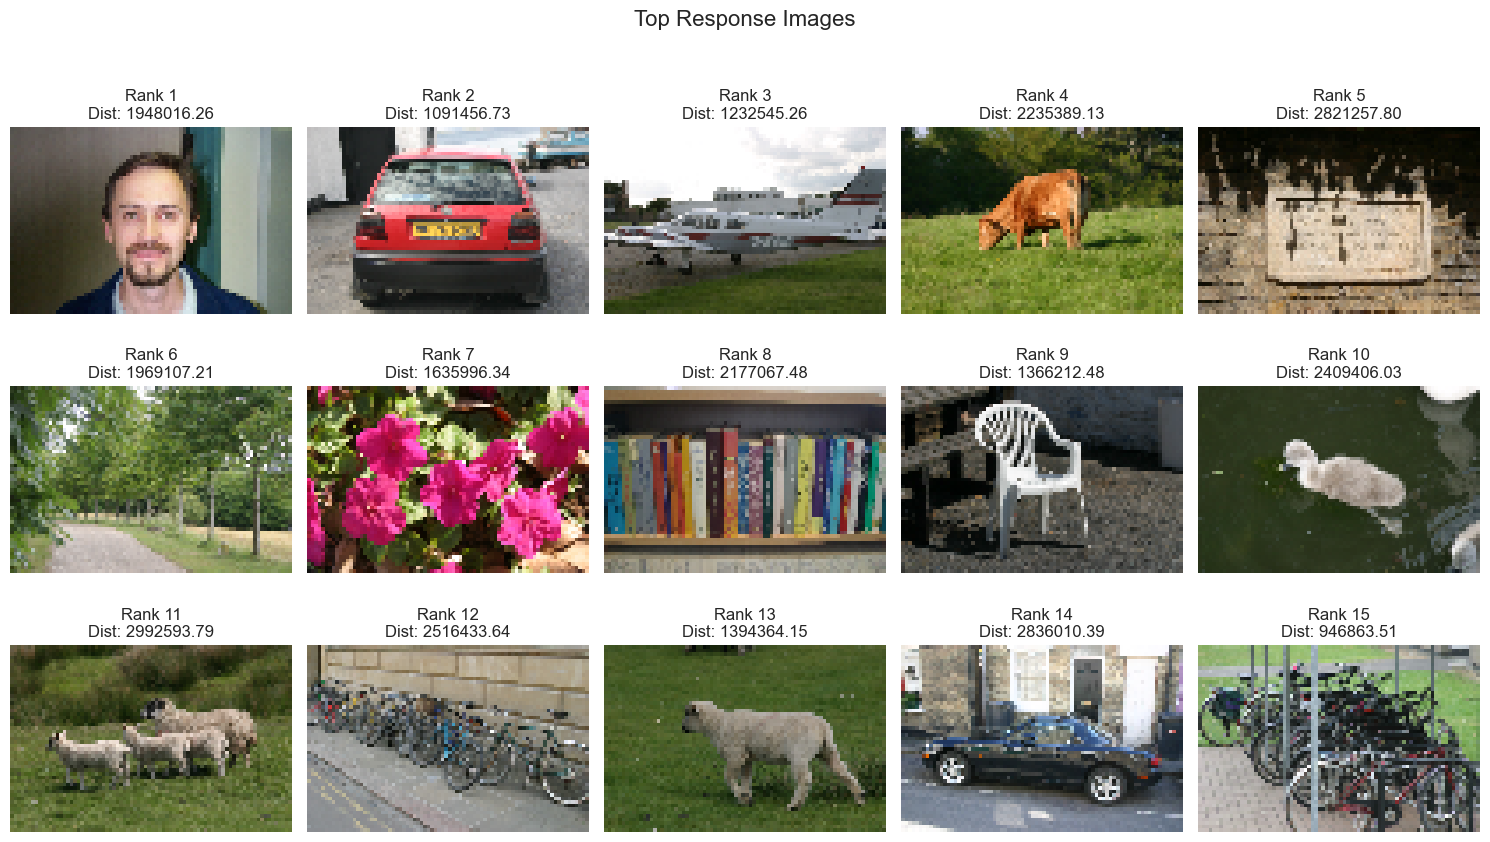

In [50]:
# Compute the distance between the query and all other descriptors
dst_col_ang_bin_level = []
COL_ANG_HIST_LEVEL = COLOR_HIST_ALLFEAT + ANGULAR_HIST_ALLFEAT

query = COL_ANG_HIST_LEVEL[queryimg]
for i in range(NIMG):
    candidate = COL_ANG_HIST_LEVEL[i]
    distance = cvpr_compare(query, candidate,'L2') 
    dst_col_ang_bin_level.append((distance, i))

display_query_and_top_responses(query_img_index = queryimg, 
                                    response_indices=dst_col_ang_bin_level, 
                                    file_paths = ALLFILES, num_responses=15, grid_shape=(3, 5))

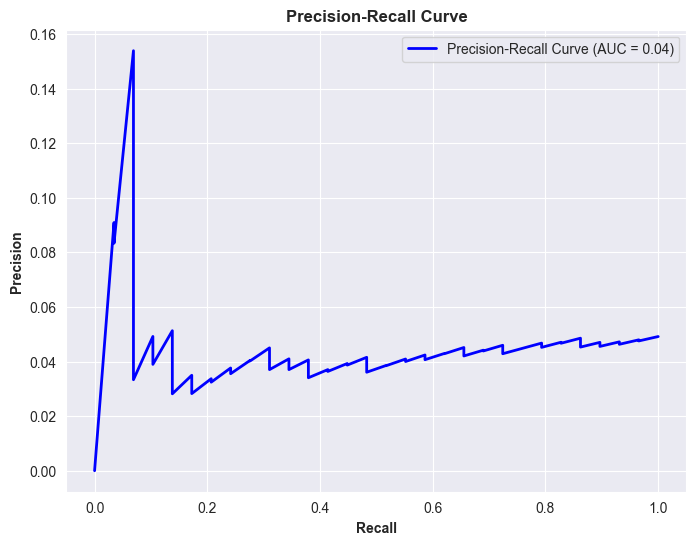

In [51]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst_col_ang_bin_level[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

plot_precision_recall_curve(response_class, query_class)

# Task 4 : Use of PCA  

In [76]:
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.distance import mahalanobis

# Function to calculate Mahalanobis distance between two descriptors
def mahalanobis_distance(descriptor1, descriptor2, inv_cov_matrix):
    return mahalanobis(descriptor1, descriptor2, inv_cov_matrix)

variance_to_explain = 0.9 

pca = PCA(n_components = variance_to_explain) 

### Task 4.1 : Colour And Angular Histogram

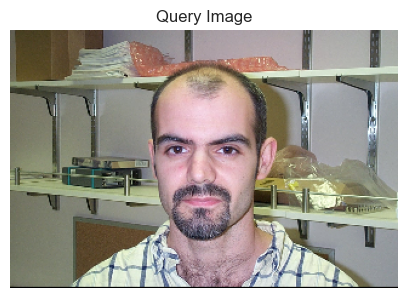

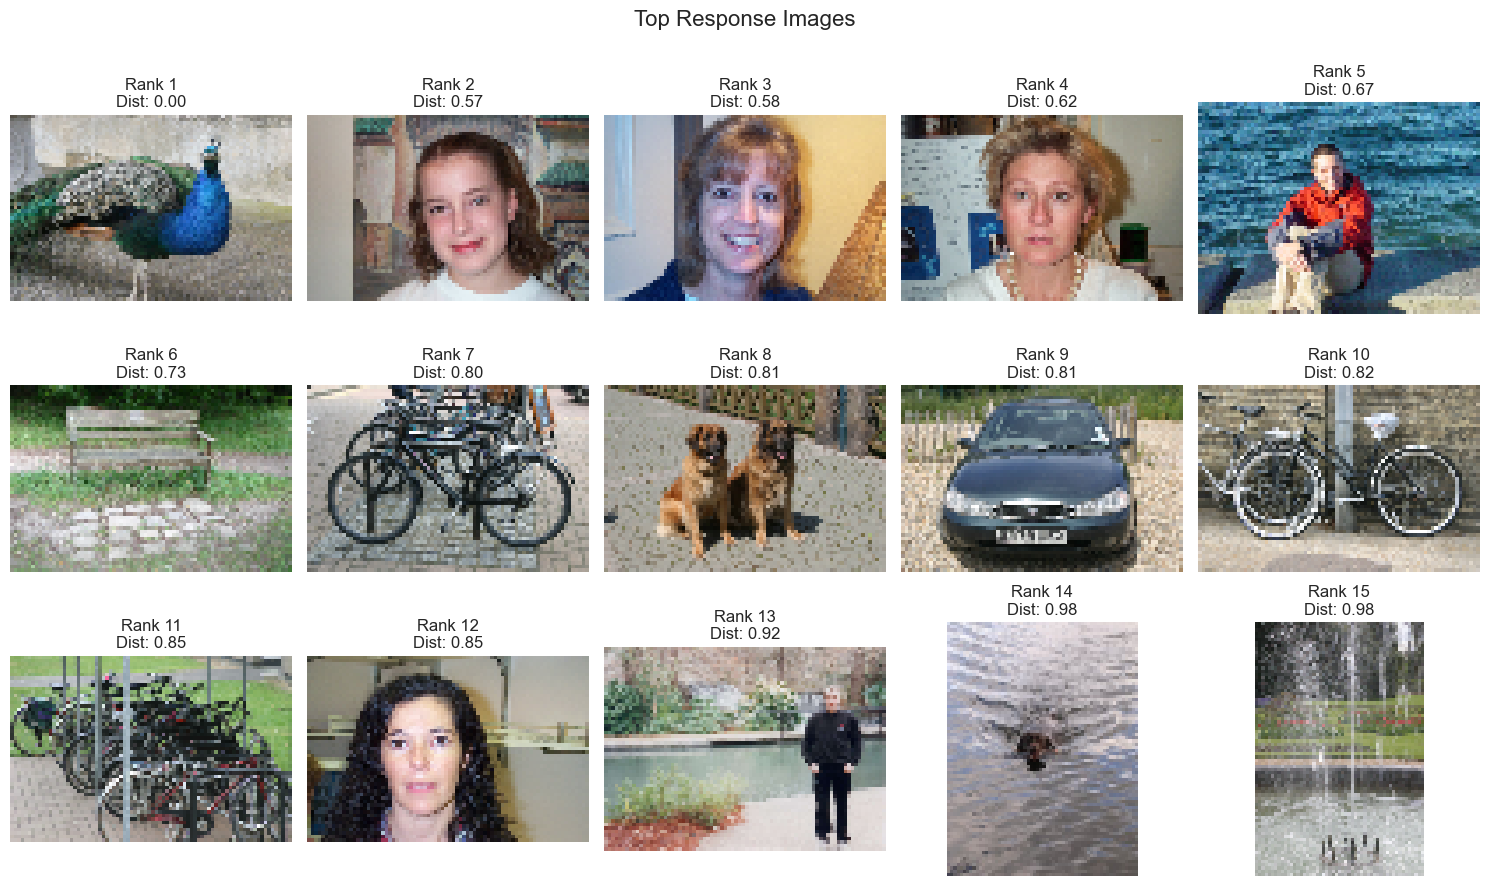

In [77]:
# Fit PCA on descriptors and transform them to lower dimensional space
COL_ANG_HIST_ALLFEAT_REDUCED = pca.fit_transform(COL_ANG_HIST_ALLFEAT)

# Compute the covariance matrix for low-dimensional descriptors
cov_matrix = np.cov(COL_ANG_HIST_ALLFEAT_REDUCED, rowvar=False)
# Calculate the inverse covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the distance between the query and all other descriptors
dst_col_mag = []
query = COL_ANG_HIST_ALLFEAT_REDUCED[queryimg]
for i in range(NIMG):
    candidate = COL_ANG_HIST_ALLFEAT_REDUCED[i]
    distance = mahalanobis_distance(query, candidate,inv_cov_matrix) 
    dst_col_mag.append((distance, i))

# Sort the distances
dst_col_mag.sort(key=lambda x: x[0])

display_query_and_top_responses(query_img_index = queryimg, 
                                    response_indices=dst_col_mag, 
                                    file_paths = ALLFILES, num_responses=15, grid_shape=(3, 5))

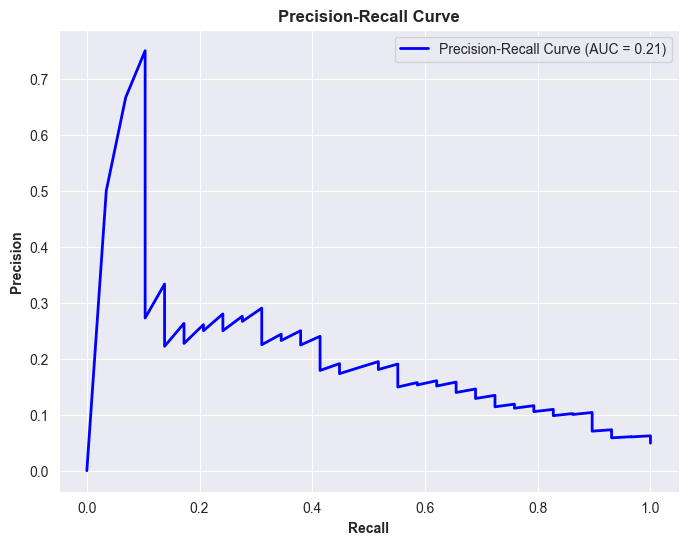

In [78]:
from cvpr_toolset import extract_class_and_file

response_class_no = []
for img_no in range(len(ALLFILES)):
    temp_class , temp_file = extract_class_and_file(ALLFILES[dst_col_mag[img_no][1]])
    response_class_no.append(temp_class)
    

query_class =   response_class_no[0]
response_class = response_class_no[1:]

plot_precision_recall_curve(response_class, query_class)

## Task 5: Different descriptors and distance measures